# Car vs. Non-car Color Space Exploration

This notebook includes some steps to visualize the car and non-car images in various color space. Spatial binning, historgram and HOG features are experimented on different channels in different color space to establish a good starting point for the parameter tuning in the project.

## Import Dataset

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

try:
    dataset = pickle.load(open('dataset.pickle', 'rb'))
    veh_img = np.array(dataset['vehicle_images'])
    non_veh_img = np.array(dataset['non_vehicle_images'])
    print("Dataset exists. File loaded.")
except (OSError, IOError) as e:
    print("CANNOT FIND DATASET IN CURRENT DIRECTORY!")

Dataset exists. File loaded.


Dataset has been loaded and the images are in RGB format.

In [2]:
# define 5 color spaces to compare
color_space = ['RGB', 'HSV', 'HLS', 'YUV', 'LAB']
def color_hist(img, axes, nbins=32, bins_range=(0, 256), color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    else: feature_image = np.copy(img)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(feature_image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(feature_image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(feature_image[:,:,2], bins=nbins, range=bins_range)
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    axes[0].bar(bin_centers, channel1_hist[0])
    axes[0].set_title("Histogram of {} channel".format(color_space[0]))
    axes[0].set_xlim(0, 256)
    axes[1].bar(bin_centers, channel2_hist[0])
    axes[1].set_title("Histogram of {} channel".format(color_space[1]))
    axes[1].set_xlim(0, 256)
    axes[2].bar(bin_centers, channel3_hist[0])
    axes[2].set_title("Histogram of {} channel".format(color_space[2]))
    axes[2].set_xlim(0, 256)

### RGB Channel Histogram

In [3]:
np.random.seed(1000)
rand_ind = np.random.randint(0, len(veh_img), size=4)
test_veh_img = veh_img[rand_ind]
test_non_veh_img = non_veh_img[rand_ind]
#test_non_veh_img = non_veh_img[np.random.randint(0, high=len(non_veh_img), size=5)]

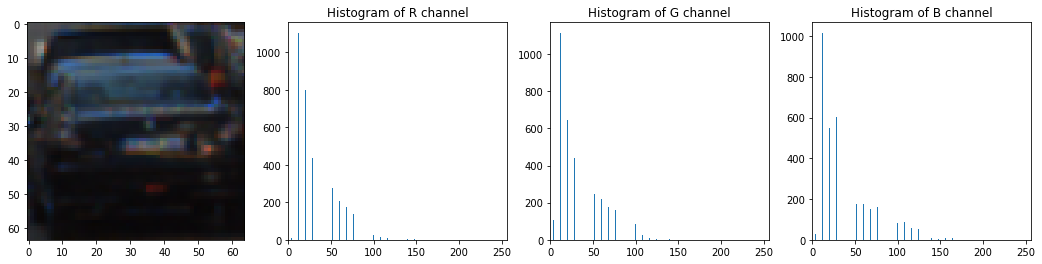

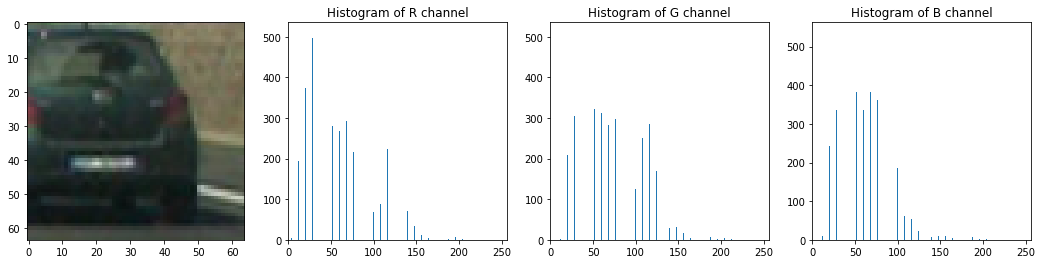

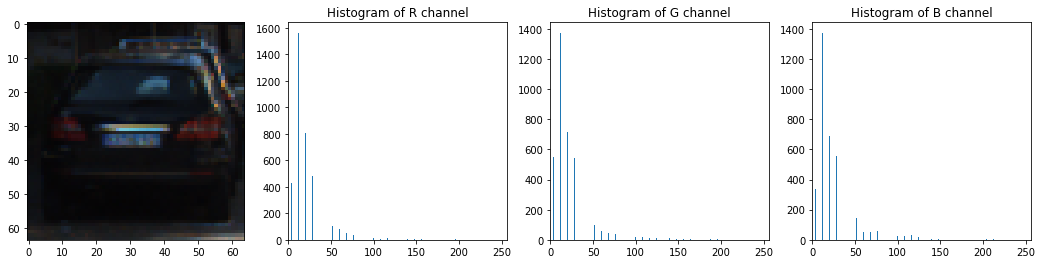

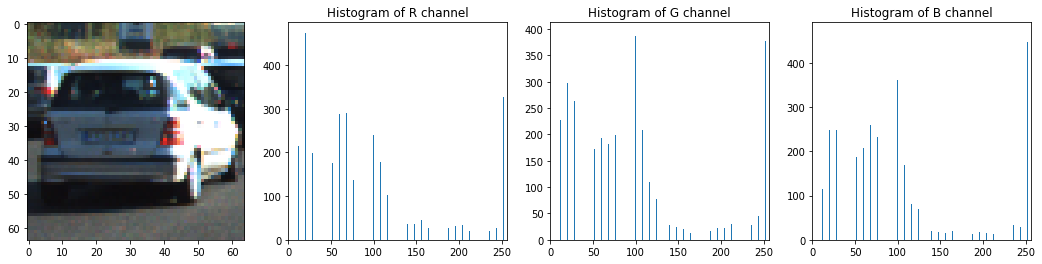

In [4]:
for i, img in enumerate(test_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4])

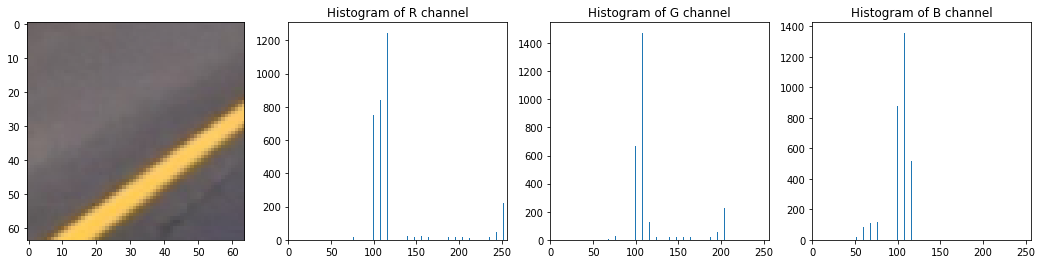

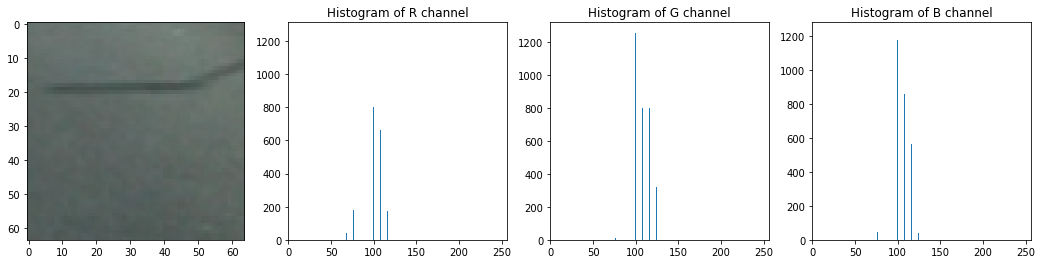

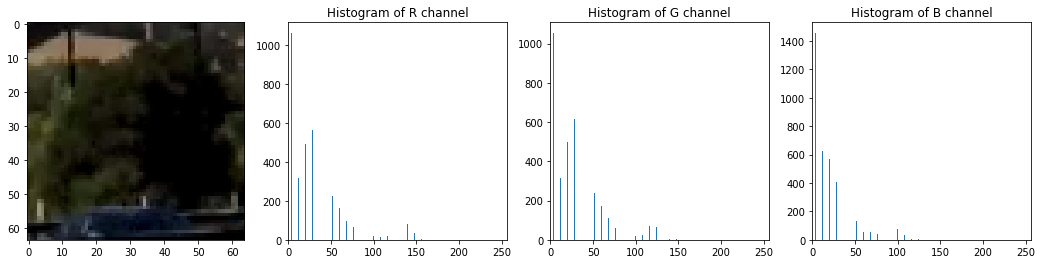

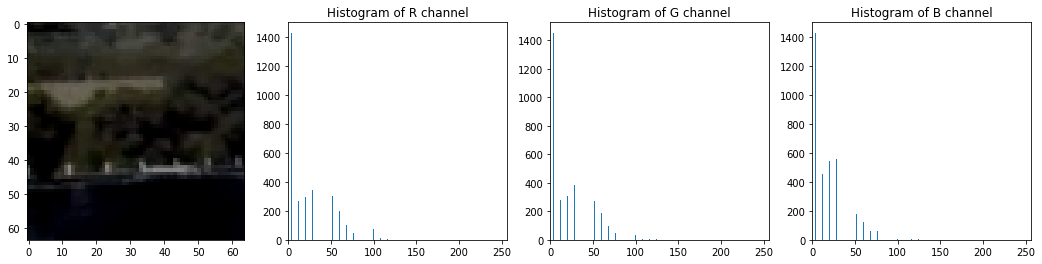

In [5]:
for i, img in enumerate(test_non_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4])

It can be found that for car images, the histogram of RGB channels have a wider spread while that for non-car images are narrower. Therefore, RGB is a good candidate channel for color histogram.

## HSV Channel Histogram

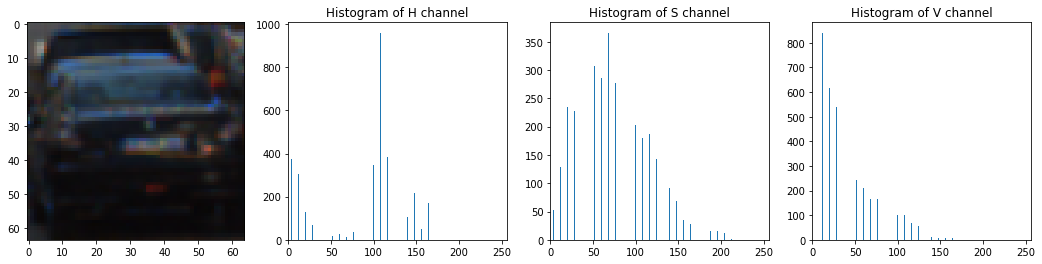

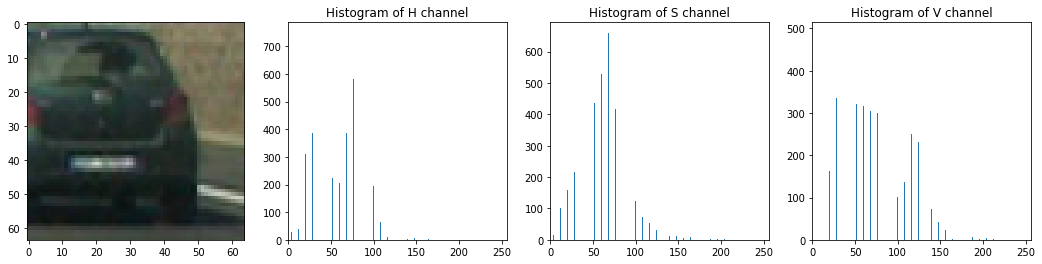

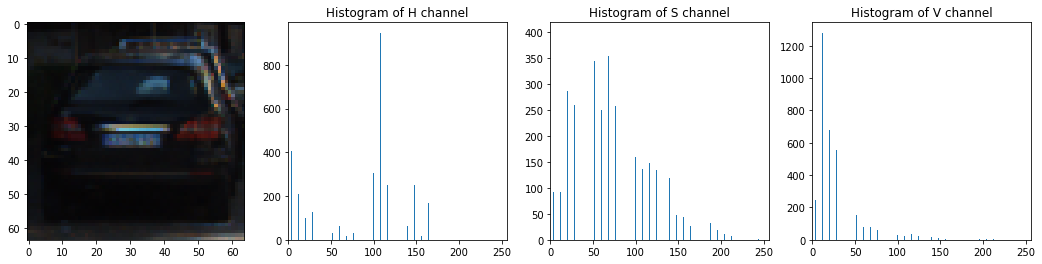

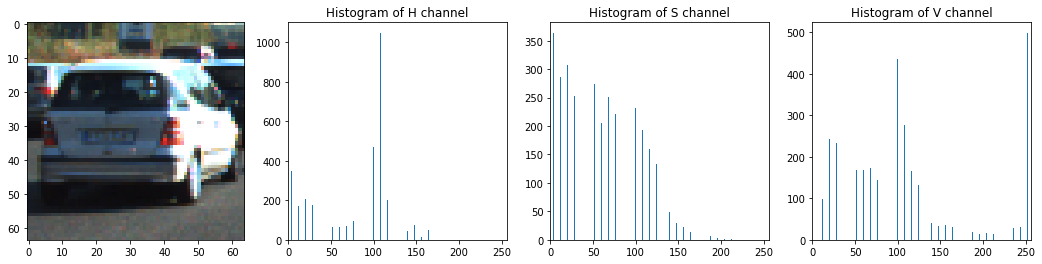

In [6]:
for i, img in enumerate(test_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4], color_space='HSV')

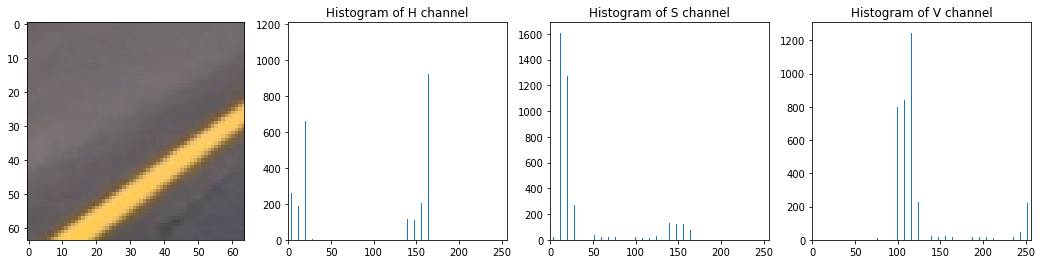

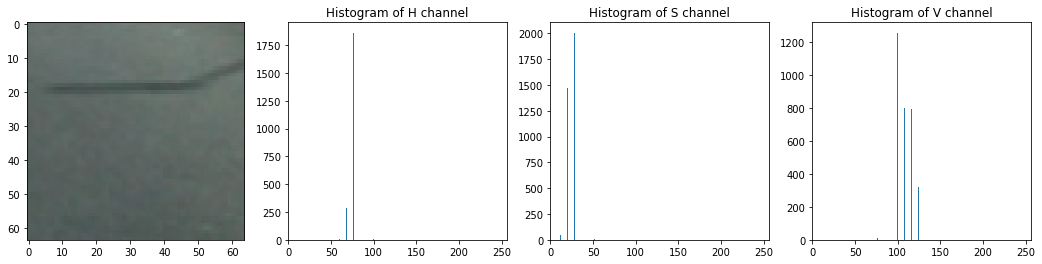

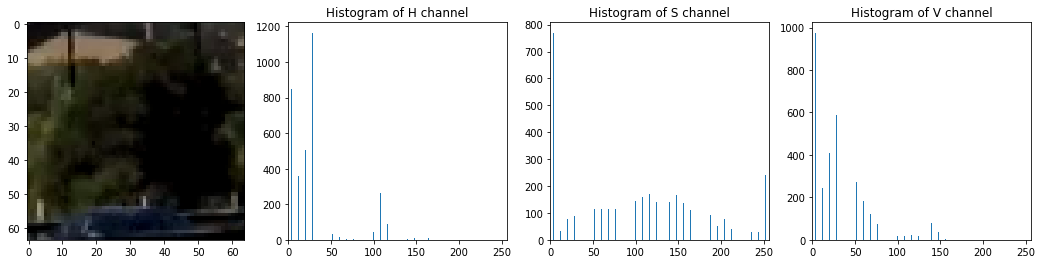

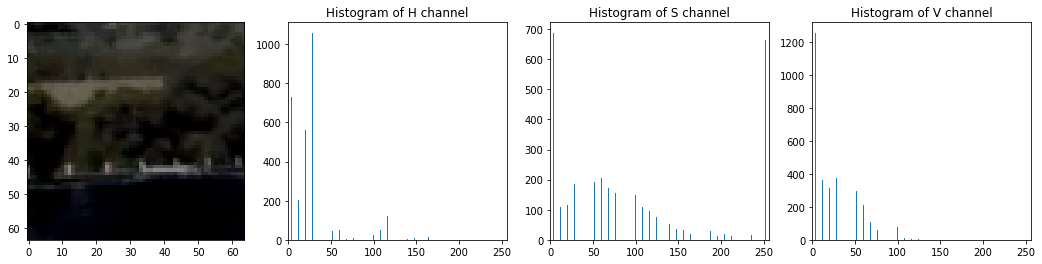

In [7]:
for i, img in enumerate(test_non_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4], color_space='HSV')

Again, it seems to be a difference between the histogram of car and non-car images. Specifically, the histogram of car images, especially for S and V channel, are positive skewed and also, the spread is wider.

## HLS Channel Histogram

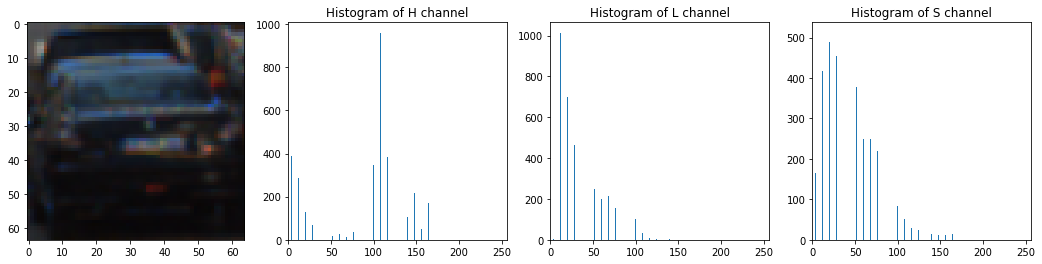

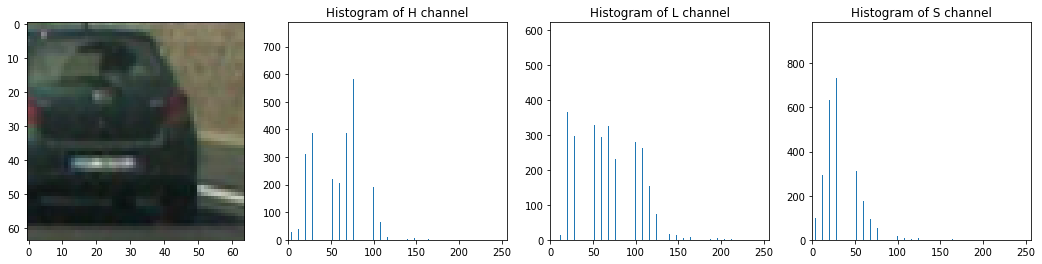

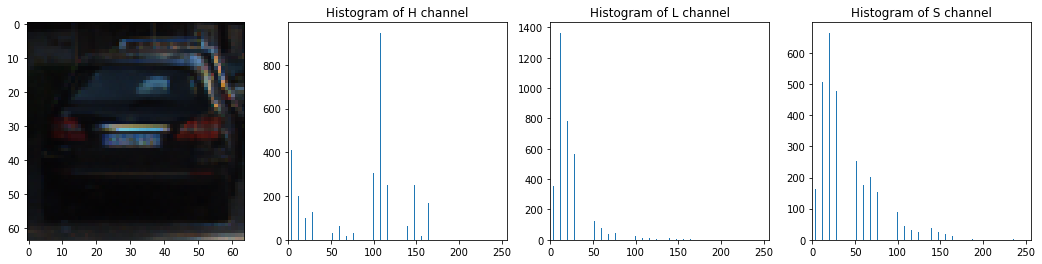

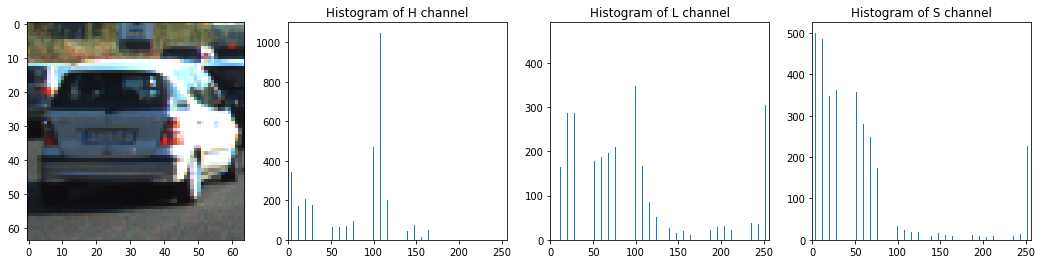

In [8]:
for i, img in enumerate(test_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4], color_space='HLS')

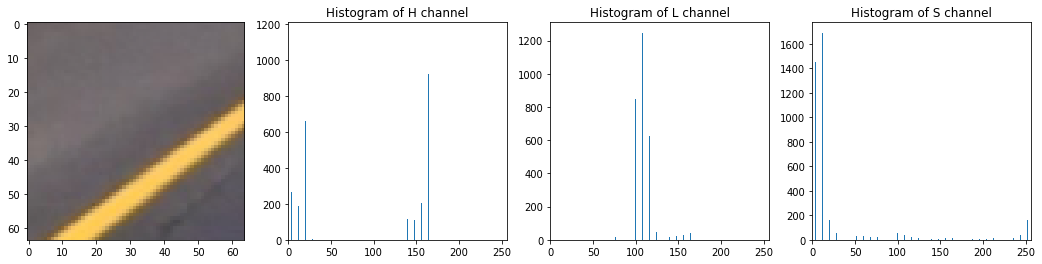

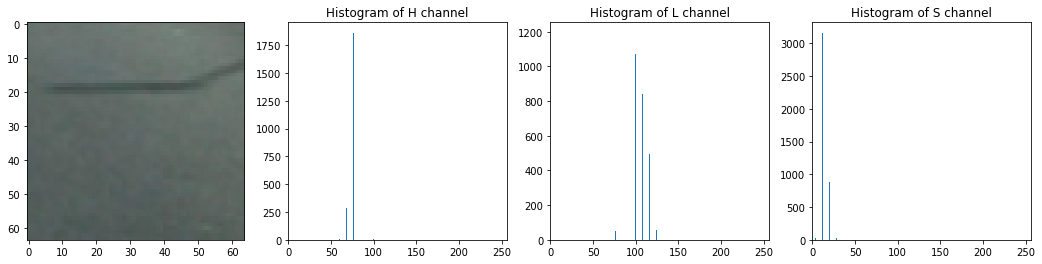

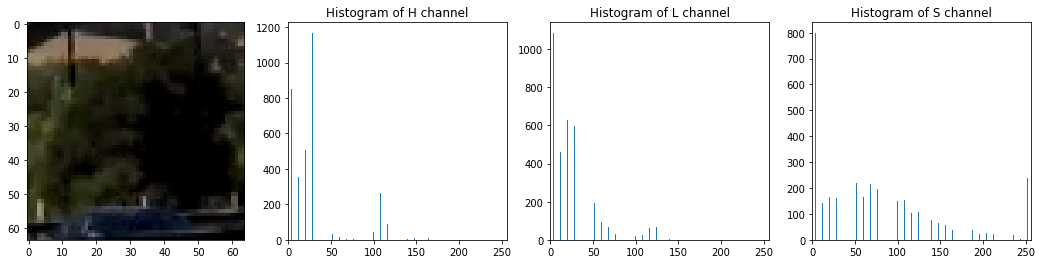

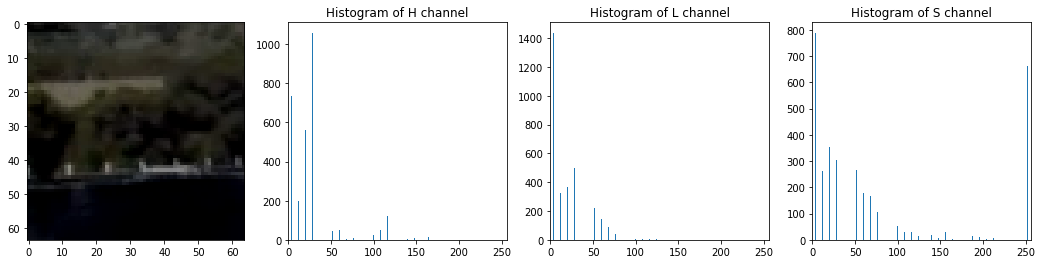

In [9]:
for i, img in enumerate(test_non_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4], color_space='HLS')

HLS is probably also acceptable but I don't think it will provide as good a color historgram feature as RGB and HSV spaces. The reason is that the spread seems to be less distinctive.

## YUV Channel Histogram

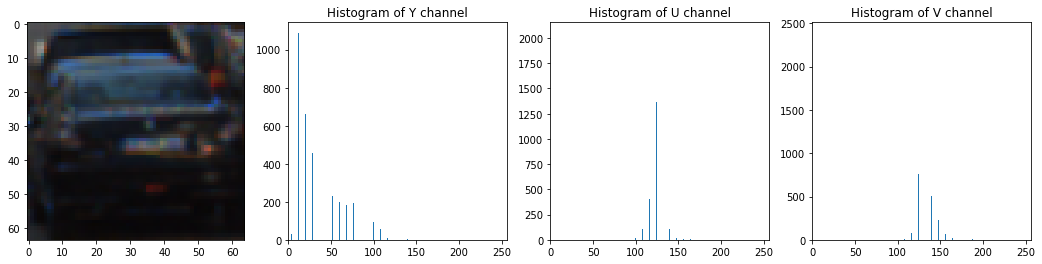

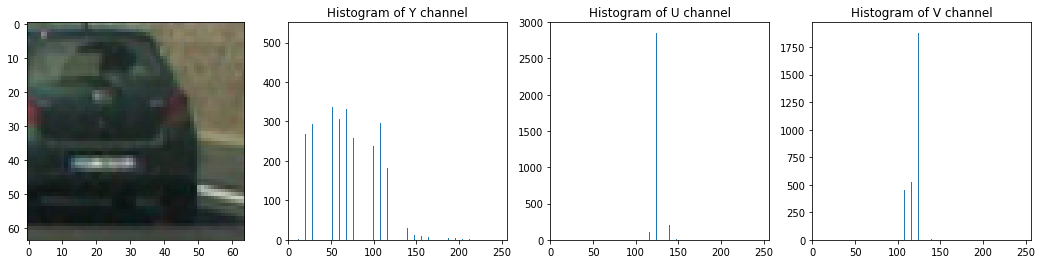

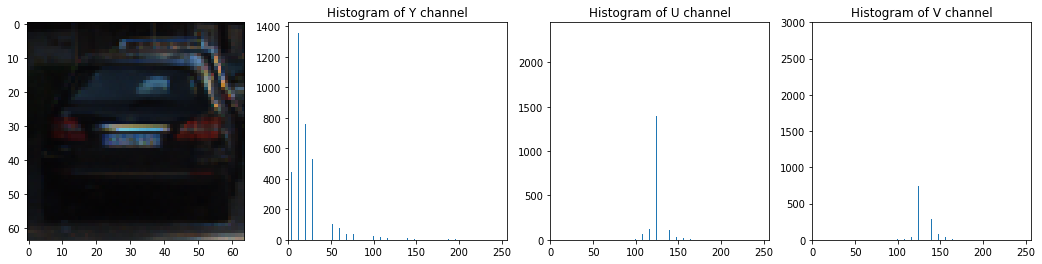

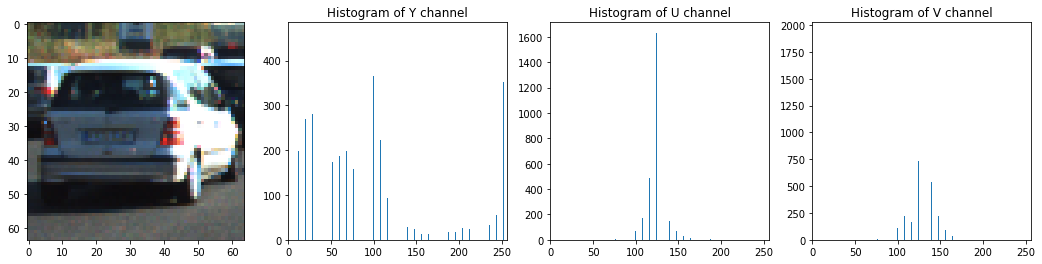

In [10]:
for i, img in enumerate(test_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4], color_space='YUV')

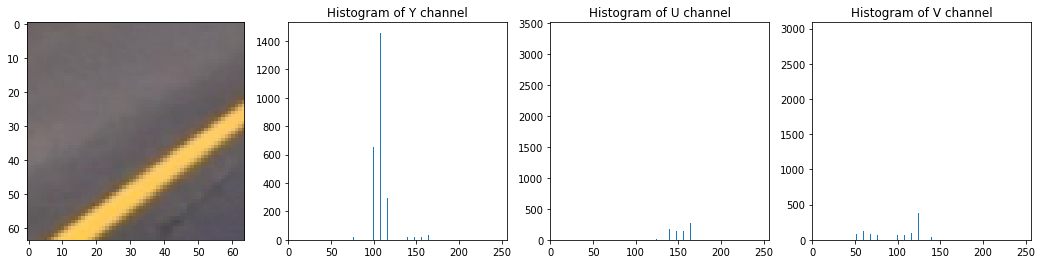

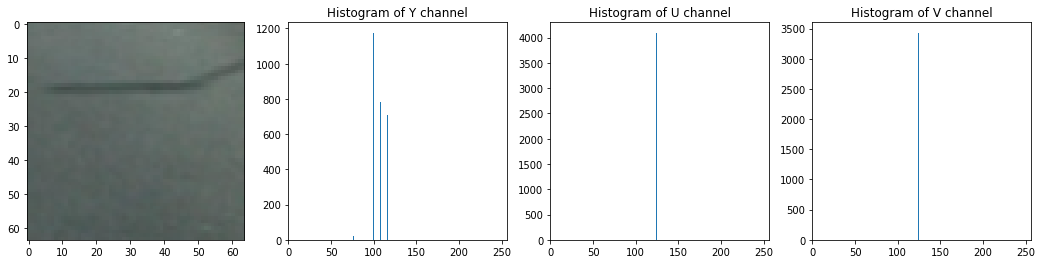

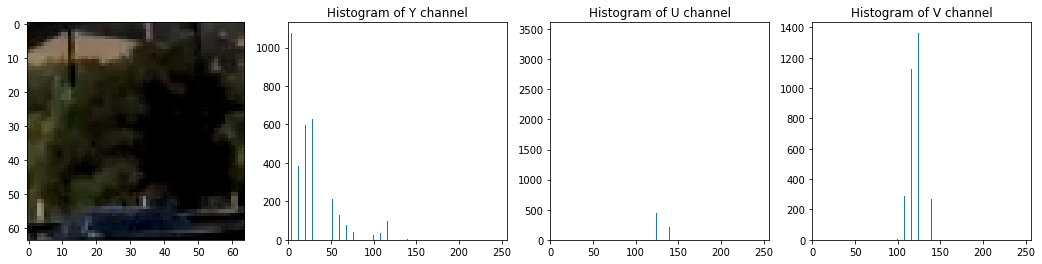

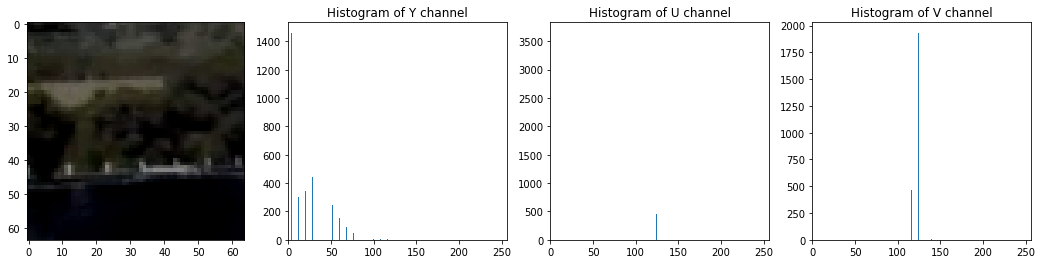

In [11]:
for i, img in enumerate(test_non_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4], color_space='YUV')

Most of differences are in the Y channel. This color space is not ideal either.

## LAB Channel Histogram

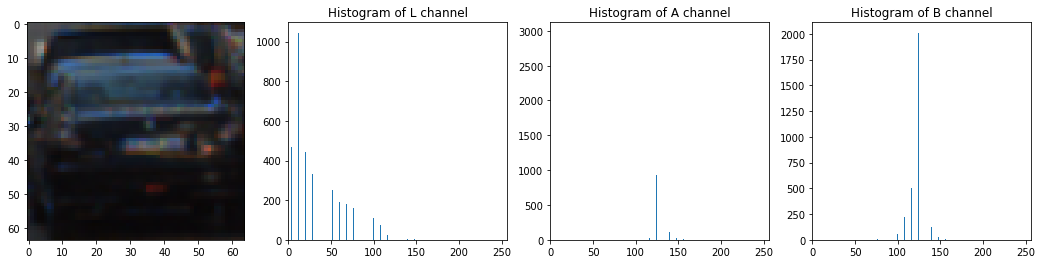

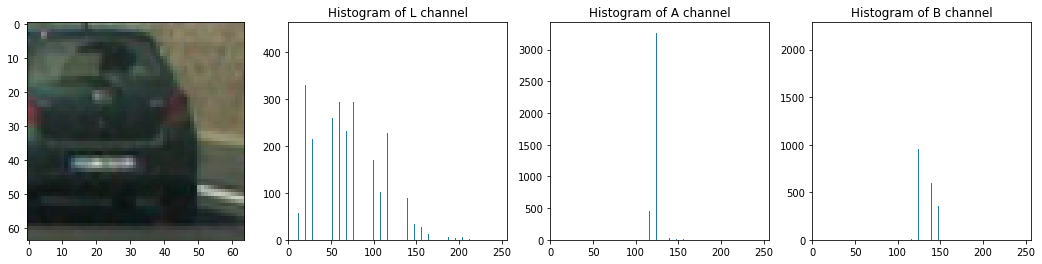

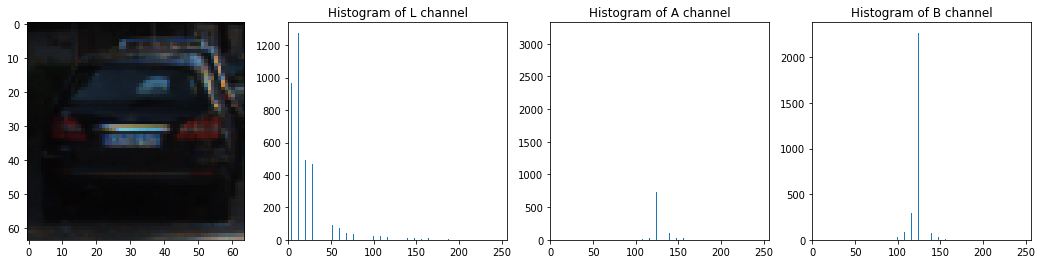

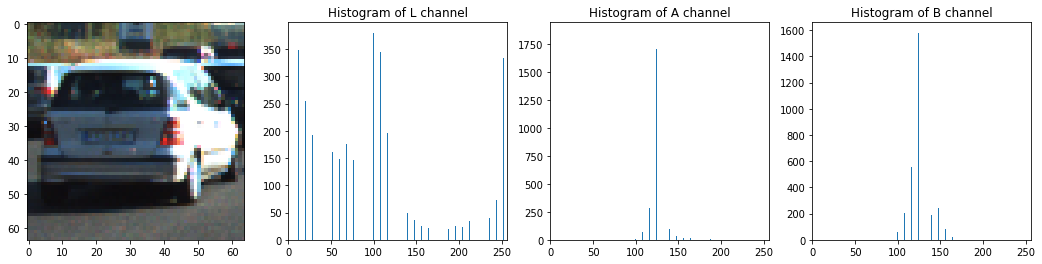

In [12]:
for i, img in enumerate(test_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4], color_space='LAB')

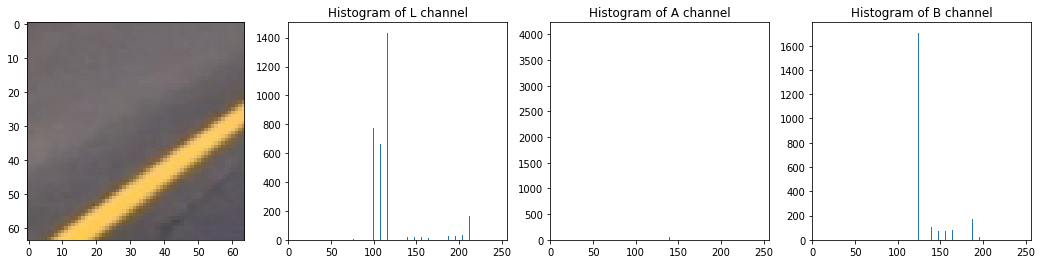

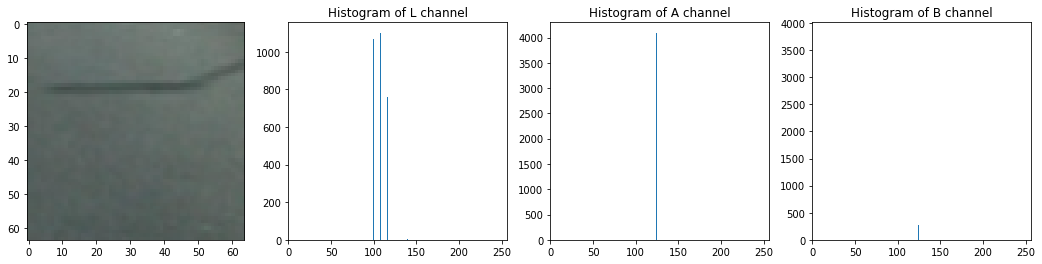

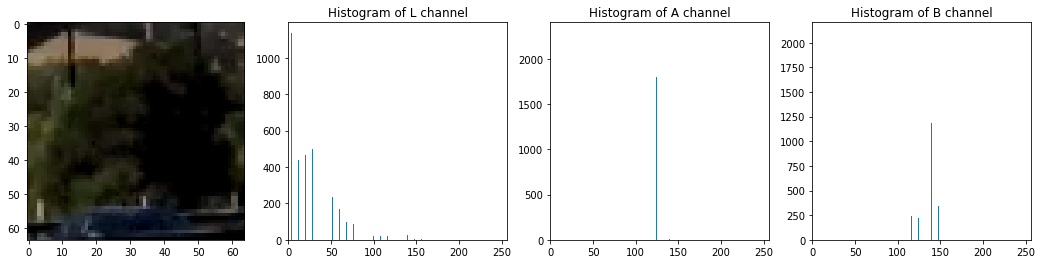

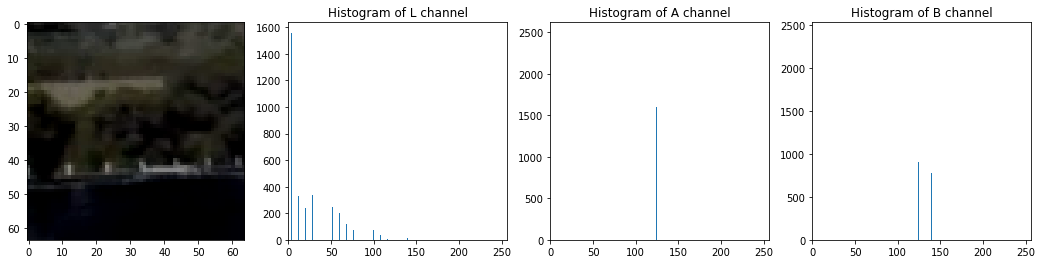

In [13]:
for i, img in enumerate(test_non_veh_img):
    f, axes = plt.subplots(1, 4, figsize=(18,4))
    axes[0].imshow(img)
    color_hist(img, axes[1:4], color_space='LAB')

Similar to YUV space, all the differences are only in L channel. Not ideal.

#### Both RGB and HSV seems to be good for color histogram features. In the project it will be helpful to compare the results of classification using these two features.

## HOG Parameters

Just like investigation of individual channels, it is possible to operate HOG feature extraction on different individual channels and color spaces. However, it has been shown that for some color spaces, for example, YUV and LAB, no significant difference can be found with the channel histogram in more than 1 channel. Therefore, it is reasonable to assume that only RGB and HSV space is worthwhile to be studied.

In [14]:
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### RGB HOG

In [15]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

C:\Users\mscwu\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


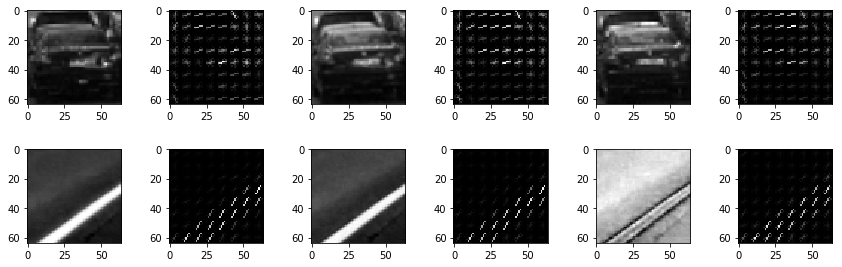

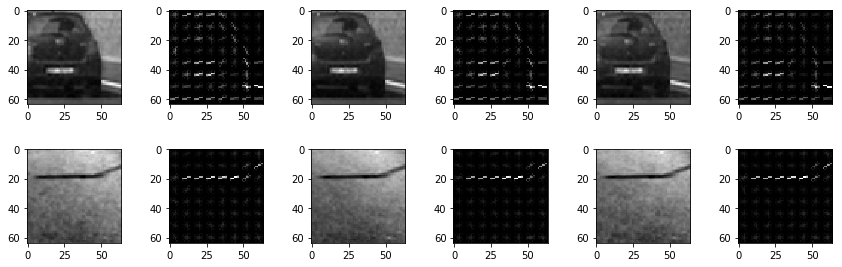

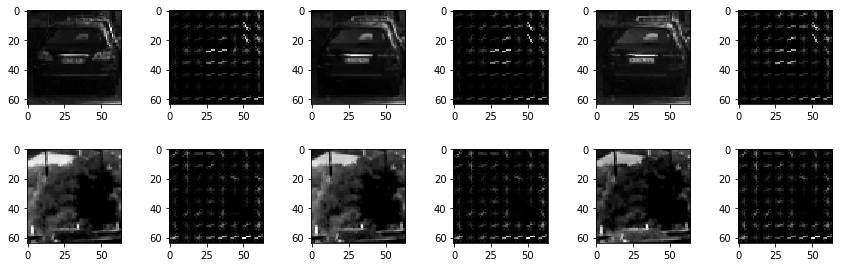

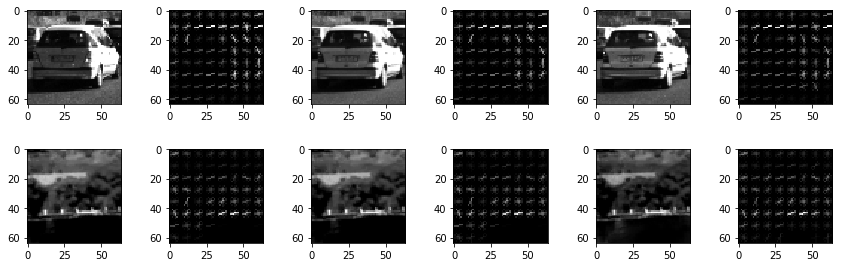

In [18]:
for veh, non_veh in zip(test_veh_img, test_non_veh_img):
    f, axes = plt.subplots(2, 6, figsize=(12,4))
    f.tight_layout()
    features_veh1, hog_image_veh1 = get_hog_features(veh[:,:,0], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)                                                     
    features_non_veh1, hog_image_non_veh1 = get_hog_features(non_veh[:,:,0], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)
    features_veh2, hog_image_veh2 = get_hog_features(veh[:,:,1], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)                                                     
    features_non_veh2, hog_image_non_veh2 = get_hog_features(non_veh[:,:,1], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)
    features_veh3, hog_image_veh3 = get_hog_features(veh[:,:,2], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)                                                     
    features_non_veh3, hog_image_non_veh3 = get_hog_features(non_veh[:,:,2], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)
    axes[0][0].imshow(veh[:,:,0], cmap='gray')
    axes[0][1].imshow(hog_image_veh1, cmap='gray')
    axes[0][2].imshow(veh[:,:,1], cmap='gray')
    axes[0][3].imshow(hog_image_veh2, cmap='gray')
    axes[0][4].imshow(veh[:,:,2], cmap='gray')
    axes[0][5].imshow(hog_image_veh3, cmap='gray')
    axes[1][0].imshow(non_veh[:,:,0], cmap='gray')
    axes[1][1].imshow(hog_image_non_veh1, cmap='gray')
    axes[1][2].imshow(non_veh[:,:,1], cmap='gray')
    axes[1][3].imshow(hog_image_non_veh2, cmap='gray')
    axes[1][4].imshow(non_veh[:,:,2], cmap='gray')
    axes[1][5].imshow(hog_image_non_veh3, cmap='gray') 

It can be found that the HOG feature of vehicle is different from that of non-vehicle. That last two samples show equally complex HOG feature for both vehicle and non-vehicle but we can clearly tell the shape a a car from the vehicle image.

### HSV HOG

C:\Users\mscwu\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


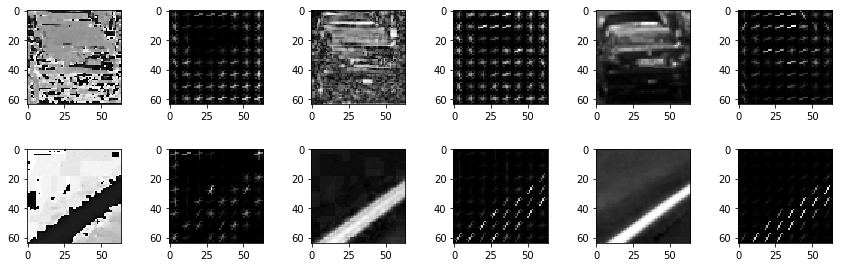

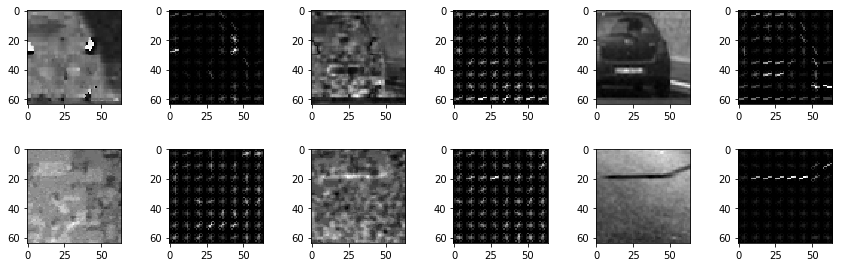

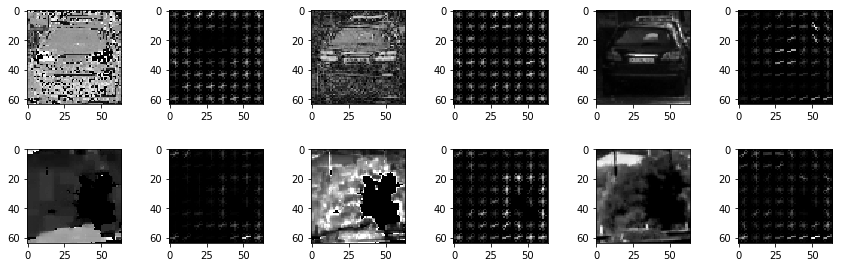

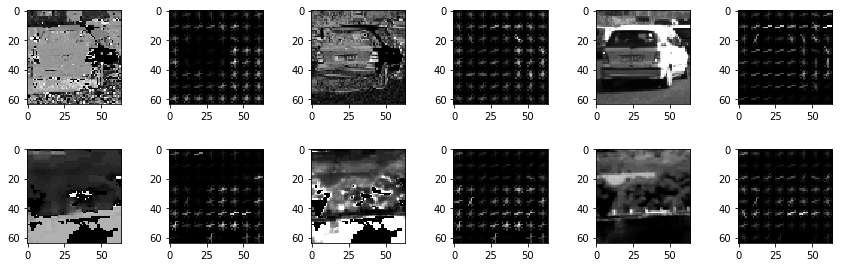

In [21]:
for veh, non_veh in zip(test_veh_img, test_non_veh_img):
    f, axes = plt.subplots(2, 6, figsize=(12,4))
    f.tight_layout()
    veh = cv2.cvtColor(veh, cv2.COLOR_RGB2HSV)
    non_veh = cv2.cvtColor(non_veh, cv2.COLOR_RGB2HSV)
    features_veh1, hog_image_veh1 = get_hog_features(veh[:,:,0], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)                                                     
    features_non_veh1, hog_image_non_veh1 = get_hog_features(non_veh[:,:,0], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)
    features_veh2, hog_image_veh2 = get_hog_features(veh[:,:,1], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)                                                     
    features_non_veh2, hog_image_non_veh2 = get_hog_features(non_veh[:,:,1], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)
    features_veh3, hog_image_veh3 = get_hog_features(veh[:,:,2], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)                                                     
    features_non_veh3, hog_image_non_veh3 = get_hog_features(non_veh[:,:,2], orient=orient,
                                                   pix_per_cell=pix_per_cell, 
                                                   cell_per_block=cell_per_block,
                                                   vis=True, feature_vec=True)
    axes[0][0].imshow(veh[:,:,0], cmap='gray')
    axes[0][1].imshow(hog_image_veh1, cmap='gray')
    axes[0][2].imshow(veh[:,:,1], cmap='gray')
    axes[0][3].imshow(hog_image_veh2, cmap='gray')
    axes[0][4].imshow(veh[:,:,2], cmap='gray')
    axes[0][5].imshow(hog_image_veh3, cmap='gray')
    axes[1][0].imshow(non_veh[:,:,0], cmap='gray')
    axes[1][1].imshow(hog_image_non_veh1, cmap='gray')
    axes[1][2].imshow(non_veh[:,:,1], cmap='gray')
    axes[1][3].imshow(hog_image_non_veh2, cmap='gray')
    axes[1][4].imshow(non_veh[:,:,2], cmap='gray')
    axes[1][5].imshow(hog_image_non_veh3, cmap='gray') 

Again, there is some difference between vehicle and non-vehicle HOG images, although the HOG image is now more abstract that that of RGB color space.

### After above study, I decide to use both RGB and HSV space for feature extraction in my project. I will compare the results and select the better one.